Build a model based on the data you have scraped. Don't worry if the model is far from perfect. You can always improve later. The most important thing is your story, you can answer the following questions after you finish modeling.

1. Why this project is important? What problem are you trying to solve?

In the online hotel reservation channels, a significant number of reservations are called-off due to cancellations (base rate = 33%). The reasons for dramatically changed booking possibilities and customers’ behavior are unknown.

Cancellations will lower occupancy, leading to revenue loss. Additional costs of distribution channels by increasing commissions or paying for publicity to help resell the rooms. High cancellation rate will make the hotel’s ranking drop in the Online Travel Agency (OTA), thus reducing the hotel’s competency against peers, resulting in lower booking rate/prices or higher marketing costs.

2. How do you measure the model performance (metrics)? What is the benchmark?


- Step 1: Use AUC-ROC for model selection. AUC-ROC is a measure of how much the model is capable of distinguishing between two classes. A model with high predictive power is useful for extracting key features for predicting customer behaviors.
- Step 2: Use AUC-ROC curve to determine the optimal threshold of the selected model. Due to limited budgets, we aim to correctly predict the customers who are most likely to cancel their reservations and take action accordingly, so we will keep precision score as close to 100% as possible, and maximize recall score at the same time.

Some benchmark methods of reducing cancellation rate and associated revenue loss include setting discounted or advance purchase rates (sometimes goes with prepaid or restrictions on late cancellation), adopting a cautious overbooking strategy, and sending email reminders.

3. How is your model? Have achieved your goal? How to evaluate the business value of your model?

The random forest model achieves the overall best performance with an AUC-ROC of 0.95 and a precision score of 0.90. However, the model provides feature importance but do not provide
complete visibility into the coefficients as logistic regression. In the future, I plan to try out different resampling techniques to optimize the performance of logistic regression model.

The current cancellation rate is 33%. Assume that 100,000 customers made reservations each year and each cancellation resulted in 500 euros of revenue loss. With 1% decrease on the cancellation rate, the revenue loss will be reduced by 500,000 euros.

4. Any insights have you gotten from your model? Any actionable suggestions can you provide to your business partner?

Top 5 important factors for cancellation:
1.	Number of days between the date of booking and the arrival date
2.	Average price per day of the reservation
3.	Total number of special requests
4.	Duration of stay
5.	Market segment designation 

Implement overbooking strategy based on the predicted stay probability; incorporate length of stay restrictions; develop a reasonable cancellation policy; improve customer service for special requests or make marketing communications strategy for target customers who are likely to make certain special request.

5. What is the most challenging part in the project? How did you solve it? How will you futher improve your model if you get more resources and time.

The most challenging part is feature selection. For categorical features, I conducted univariate chi-square test on each variable, and ranked their importance according to the corresponding scores. If I were given more time, I would try some other methods that can be applied to select important numerical features.

Make sure that your work includes these parts:
1. **Pre-model Analysis**: process and visualize data; get insights of features and target.
2. **Problem Definition**: translate the business needs into machine learning problems; design metrics to measure model performance.
3. **Feature Engineering**: create features which might improve model performance.
4. **Modeling**: Model selection, feature elimination, validation, hyperparameter tuning.
5. **Post-model Analysis**: Model performance, feature importance, actionable suggestions to business.

In [241]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import scipy.stats
from scipy.stats import chi2

In [242]:
df = pd.read_csv('/Users/linlitang/Desktop/Techlent_hw/data/hotel_reservations.csv')

In [243]:
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [244]:
df.shape

(36275, 19)

In [245]:
# get missing value percentages per feature 
print(df.isnull().sum()/len(df)*100)

Booking_ID                              0.0
no_of_adults                            0.0
no_of_children                          0.0
no_of_weekend_nights                    0.0
no_of_week_nights                       0.0
type_of_meal_plan                       0.0
required_car_parking_space              0.0
room_type_reserved                      0.0
lead_time                               0.0
arrival_year                            0.0
arrival_month                           0.0
arrival_date                            0.0
market_segment_type                     0.0
repeated_guest                          0.0
no_of_previous_cancellations            0.0
no_of_previous_bookings_not_canceled    0.0
avg_price_per_room                      0.0
no_of_special_requests                  0.0
booking_status                          0.0
dtype: float64


In [246]:
df_num = df[['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'lead_time', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']]

In [247]:
df_num.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,85.232557,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,85.930817,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,17.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,57.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,126.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,443.000000,13.000000,58.000000,540.000000,5.000000


In [248]:
df.describe(include = 'object')

,Booking_ID,type_of_meal_plan,room_type_reserved,market_segment_type,booking_status
count,36275,36275,36275,36275,36275
unique,36275,4,7,5,2
top,INN00001,Meal Plan 1,Room_Type 1,Online,Not_Canceled
freq,1,27835,28130,23214,24390


## 2. EDA & Feature Engineering

### 2.1 Numerical variables (9)
- no_of_adults: Number of adults
- no_of_children: Number of Children
- no_of_weekend_nights: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
- no_of_week_nights: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
- lead_time: Number of days between the date of booking and the arrival date
- no_of_previous_cancellations: Number of previous bookings that were canceled by the customer prior to the current booking
- no_of_previous_bookings_not_canceled: Number of previous bookings not canceled by the customer prior to the current booking
- avg_price_per_room: Average price per day of the reservation; prices of the rooms are dynamic. (in euros)
- no_of_special_requests: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)

In [249]:
pearson_corr = df_num.corr(method='pearson')
pearson_corr

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
no_of_adults,1.000000,-0.019787,0.103316,0.105622,0.097287,-0.047426,-0.119166,0.296886,0.189401
no_of_children,-0.019787,1.000000,0.029478,0.024398,-0.047091,-0.016390,-0.021189,0.337728,0.124486
no_of_weekend_nights,0.103316,0.029478,1.000000,0.179577,0.046595,-0.020690,-0.026312,-0.004525,0.060593
no_of_week_nights,0.105622,0.024398,0.179577,1.000000,0.149650,-0.030080,-0.049344,0.022753,0.045994
lead_time,0.097287,-0.047091,0.046595,0.149650,1.000000,-0.045723,-0.078137,-0.062596,-0.101645
no_of_previous_cancellations,-0.047426,-0.016390,-0.020690,-0.030080,-0.045723,1.000000,0.468147,-0.063340,-0.003317
no_of_previous_bookings_not_canceled,-0.119166,-0.021189,-0.026312,-0.049344,-0.078137,0.468147,1.000000,-0.113684,0.027377
avg_price_per_room,0.296886,0.337728,-0.004525,0.022753,-0.062596,-0.063340,-0.113684,1.000000,0.184381
no_of_special_requests,0.189401,0.124486,0.060593,0.045994,-0.101645,-0.003317,0.027377,0.184381,1.000000


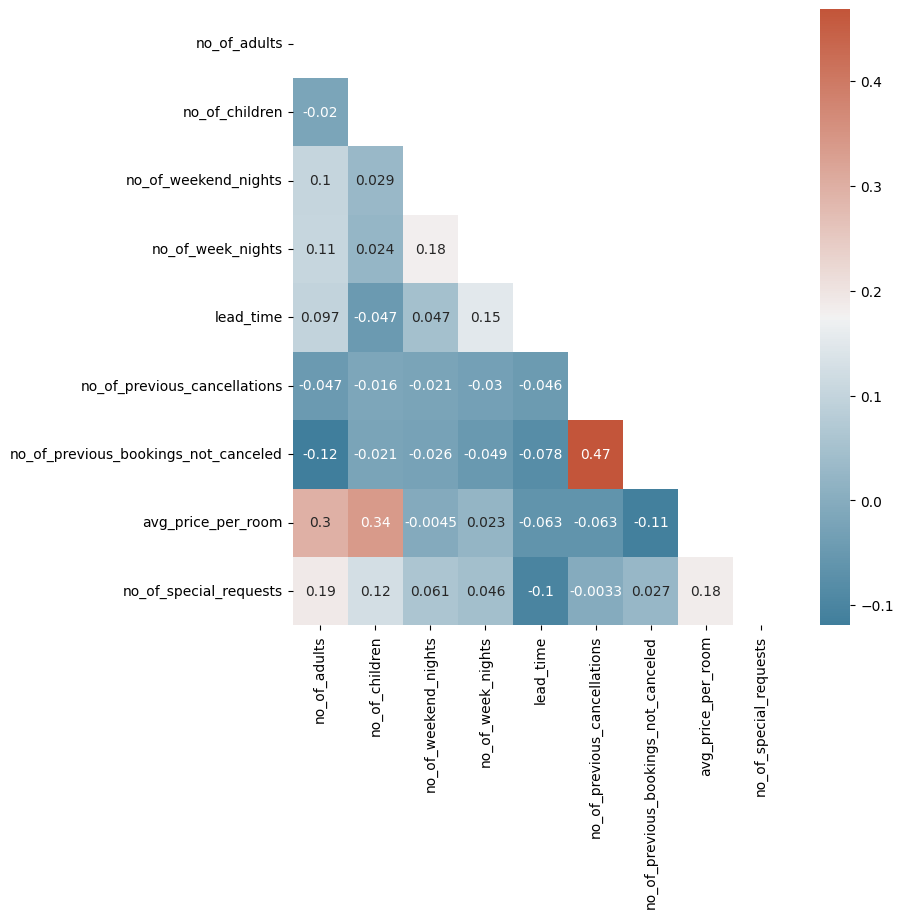

In [250]:
f, ax = plt.subplots(figsize=(8, 8))
mask = np.triu(np.ones_like(pearson_corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(pearson_corr, annot=True, mask = mask, cmap=cmap)
plt.show()

<AxesSubplot: xlabel='no_of_week_nights', ylabel='count'>

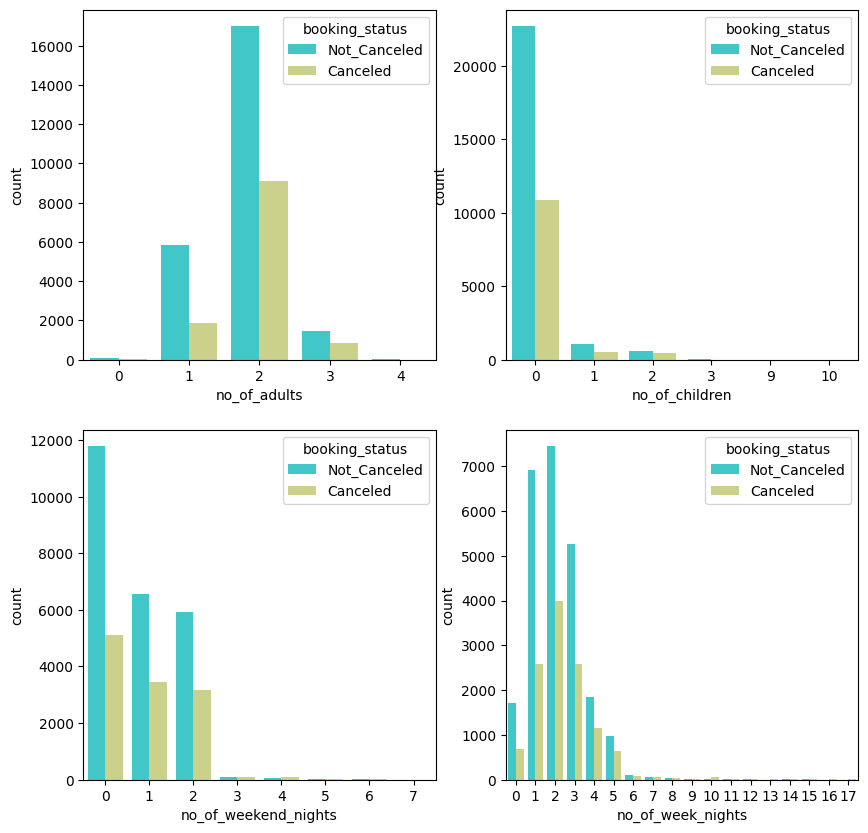

In [251]:
plt.figure(figsize = (10,10))
plt.subplot(2,2,1)
sns.countplot(x = 'no_of_adults', hue = 'booking_status', data = df, palette='rainbow')

plt.subplot(2,2,2)
sns.countplot(x = 'no_of_children', hue = 'booking_status', data = df, palette='rainbow')

plt.subplot(2,2,3)
sns.countplot(x = 'no_of_weekend_nights', hue = 'booking_status', data = df, palette='rainbow')

plt.subplot(2,2,4)
sns.countplot(x = 'no_of_week_nights', hue = 'booking_status', data = df, palette='rainbow')

In [252]:
contingency_table = pd.crosstab(df['booking_status'], df['no_of_previous_cancellations'])
print(contingency_table)

no_of_previous_cancellations     0    1   2   3   4   5   6   11  13
booking_status                                                      
Canceled                      11869   11   0   1   0   0   0   0   4
Not_Canceled                  24068  187  46  42  10  11   1  25   0


In [253]:
contingency_table = pd.crosstab(df['booking_status'], df['no_of_previous_bookings_not_canceled'])
print(contingency_table)

no_of_previous_bookings_not_canceled     0    1    2   3   4   5   6   7   8   \
booking_status                                                                  
Canceled                              11878    4    0   0   1   0   1   0   0   
Not_Canceled                          23585  224  112  80  64  60  35  24  23   

no_of_previous_bookings_not_canceled  9   ...  49  50  51  52  53  54  55  56  \
booking_status                            ...                                   
Canceled                               0  ...   0   0   0   0   0   0   0   0   
Not_Canceled                          19  ...   1   1   1   1   1   1   1   1   

no_of_previous_bookings_not_canceled  57  58  
booking_status                                
Canceled                               0   0  
Not_Canceled                           1   1  

[2 rows x 59 columns]


### 2.1 Categorical variables (8)
- type_of_meal_plan: Type of meal plan booked by the customer:
- required_car_parking_space: Does the customer require a car parking space? (0 - No, 1- Yes)
- room_type_reserved: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.
- arrival_year: Year of arrival date
- arrival_month: Month of arrival date
- arrival_date: Date of the month
- market_segment_type: Market segment designation
- repeated_guest: Is the customer a repeated guest? (0 - No, 1- Yes)

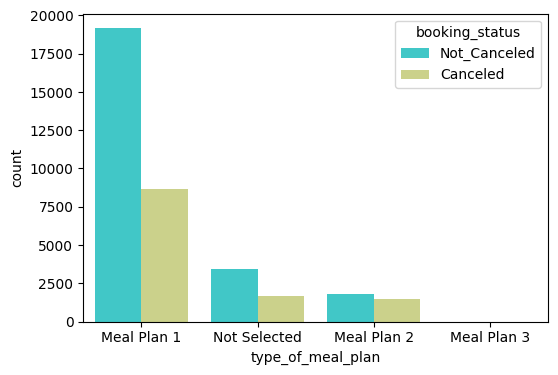

In [254]:
plt.figure(figsize = (6, 4))
sns.countplot(x = 'type_of_meal_plan', hue = 'booking_status', data = df, palette='rainbow')
plt.show()

May use this calculator to verify the results of chi-square test https://www.socscistatistics.com/tests/chisquare2/default2.aspx

In [255]:
from bioinfokit.analys import stat, get_data

res = stat()
contingency_table = pd.crosstab(df['booking_status'], df['type_of_meal_plan'])
res.chisq(df = contingency_table)
print(res.summary)


Chi-squared test for independence

Test              Df    Chi-square      P-value
--------------  ----  ------------  -----------
Pearson            3       278.295  4.95192e-60
Log-likelihood     3       266.147  2.1037e-57



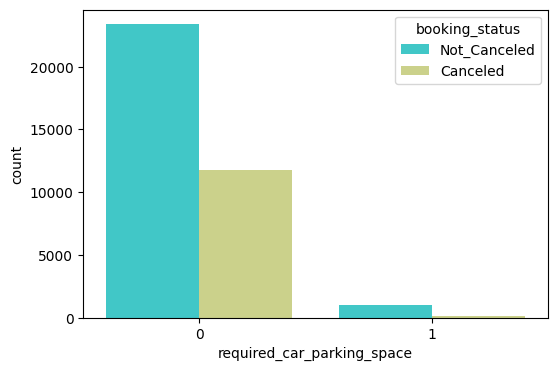

In [256]:
plt.figure(figsize = (6, 4))
sns.countplot(x = 'required_car_parking_space', hue = 'booking_status', data = df, palette='rainbow')
plt.show()

In [257]:
contingency_table = pd.crosstab(df['booking_status'], df['required_car_parking_space'])
res.chisq(df = contingency_table)
print(res.summary)


Chi-squared test for independence

Test              Df    Chi-square      P-value
--------------  ----  ------------  -----------
Pearson            1       268.388  2.54765e-60
Log-likelihood     1       325.297  1.01645e-72



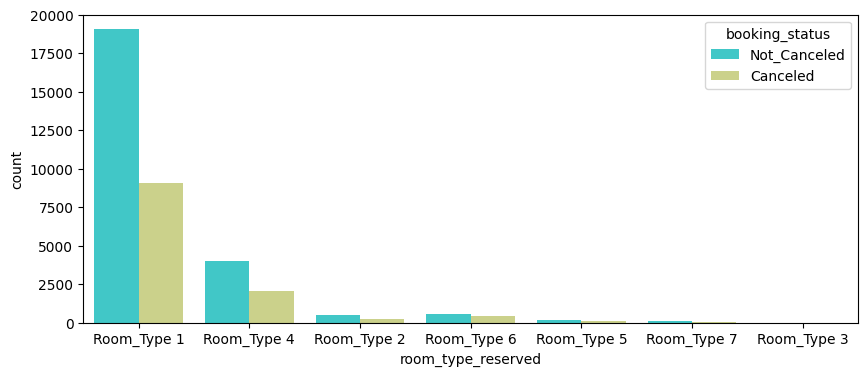

In [258]:
plt.figure(figsize = (10, 4))
sns.countplot(x = 'room_type_reserved', hue = 'booking_status', data = df, palette='rainbow')
plt.show()

In [259]:
contingency_table = pd.crosstab(df['booking_status'], df['room_type_reserved'])
res.chisq(df = contingency_table)
print(res.summary)


Chi-squared test for independence

Test              Df    Chi-square      P-value
--------------  ----  ------------  -----------
Pearson            6       57.335   1.56278e-10
Log-likelihood     6       56.4158  2.39848e-10



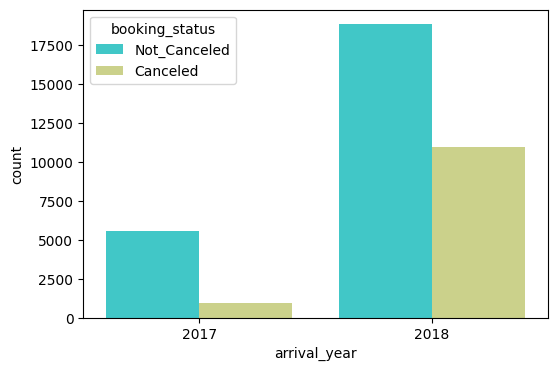

In [260]:
plt.figure(figsize = (6, 4))
sns.countplot(x = 'arrival_year', hue = 'booking_status', data = df, palette='rainbow')
plt.show()

In [261]:
contingency_table = pd.crosstab(df['booking_status'], df['arrival_year'])
res.chisq(df = contingency_table)
print(res.summary)


Chi-squared test for independence

Test              Df    Chi-square       P-value
--------------  ----  ------------  ------------
Pearson            1       1168.17  5.04686e-256
Log-likelihood     1       1307.15  3.15468e-286



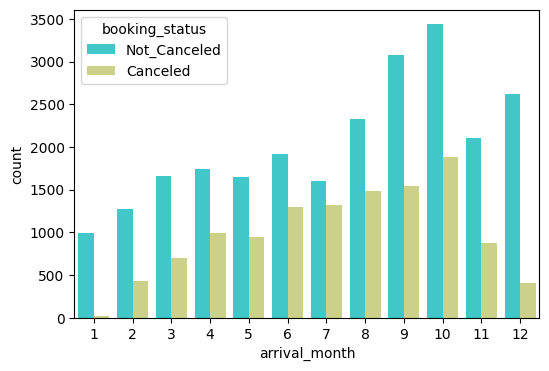

In [262]:
plt.figure(figsize = (6, 4))
sns.countplot(x = 'arrival_month', hue = 'booking_status', data = df, palette='rainbow')
plt.show()

In [263]:
contingency_table = pd.crosstab(df['booking_status'], df['arrival_month'])
res.chisq(df = contingency_table)
print(res.summary)


Chi-squared test for independence

Test              Df    Chi-square       P-value
--------------  ----  ------------  ------------
Pearson           11       1412.6   2.30696e-296
Log-likelihood    11       1674.74  0



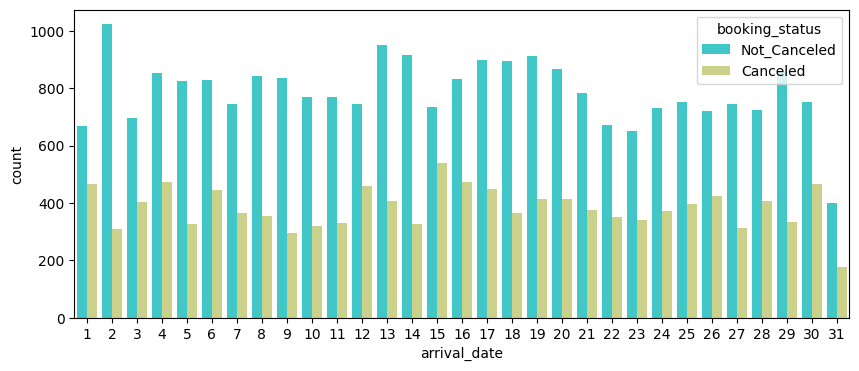

In [264]:
plt.figure(figsize = (10, 4))
sns.countplot(x = 'arrival_date', hue = 'booking_status', data = df, palette='rainbow')
plt.show()

In [265]:
contingency_table = pd.crosstab(df['booking_status'], df['arrival_date'])
res.chisq(df = contingency_table)
print(res.summary)


Chi-squared test for independence

Test              Df    Chi-square      P-value
--------------  ----  ------------  -----------
Pearson           30       321.644  1.39159e-50
Log-likelihood    30       323.353  6.37521e-51



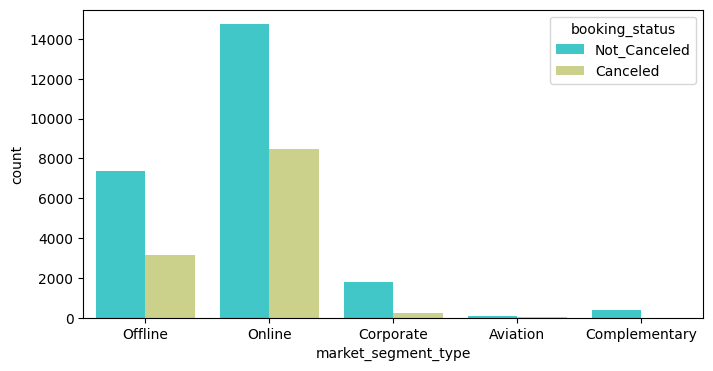

In [266]:
plt.figure(figsize = (8, 4))
sns.countplot(x = 'market_segment_type', hue = 'booking_status', data = df, palette='rainbow')
plt.show()

In [267]:
contingency_table = pd.crosstab(df['booking_status'], df['market_segment_type'])
res.chisq(df = contingency_table)
print(res.summary)


Chi-squared test for independence

Test              Df    Chi-square       P-value
--------------  ----  ------------  ------------
Pearson            4       814.109  6.74876e-175
Log-likelihood     4      1022.19   5.55488e-220



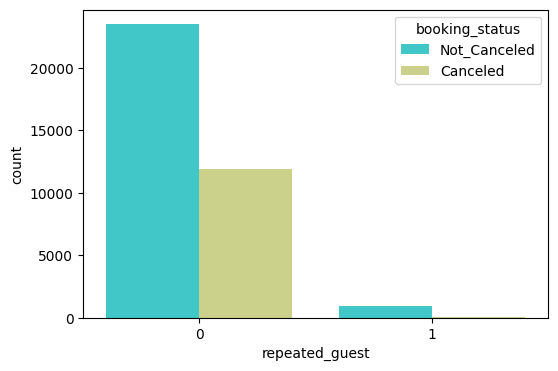

In [268]:
plt.figure(figsize = (6, 4))
sns.countplot(x = 'repeated_guest', hue = 'booking_status', data = df, palette='rainbow')
plt.show()

In [269]:
contingency_table = pd.crosstab(df['booking_status'], df['repeated_guest'])
res.chisq(df = contingency_table)
print(res.summary)


Chi-squared test for independence

Test              Df    Chi-square       P-value
--------------  ----  ------------  ------------
Pearson            1       416.096  1.72705e-92
Log-likelihood     1       606.928  5.21007e-134



In [270]:
def process_booking_date(df):
    df.drop(columns=['year', 'month', 'day'], inplace=True, errors='ignore')
    
    temp = df.rename(columns={
        'arrival_year': 'year',
        'arrival_month': 'month',
        'arrival_date': 'day'
    })

    df['booking_date'] = pd.to_datetime(temp[['year', 'month', 'day']], errors='coerce')
    df['booking_date'] = df['booking_date'] - pd.Series(
        [pd.Timedelta(i, 'd') for i in df.lead_time],
        index=df.index
    )
    
    #df['booking_year'] = df['booking_date'].dt.year
    #df['booking_month'] = df['booking_date'].dt.month
    #df['booking_week'] = df['booking_date'].dt.isocalendar().week.astype(float)
    #df['booking_day'] = df['booking_date'].dt.day
    #df['booking_dayofweek'] = df['booking_date'].dt.dayofweek
    #df['booking_quarter'] = df['booking_date'].dt.quarter
    #df['booking_dayofyear'] = df['booking_date'].dt.dayofyear
    
    #df.drop(columns='booking_date', inplace=True)
    return df
new_df = process_booking_date(df)
print(new_df.columns)
new_df.head()

Index(['Booking_ID', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status',
       'booking_date'],
      dtype='object')


,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,booking_date
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled,2017-02-20
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled,2018-11-01
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled,2018-02-27
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled,2017-10-21
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled,2018-02-22


In [271]:
new_df.shape

(36275, 20)

In [272]:
# drop all records with invalid date (37 records)
new_df.dropna(subset=['booking_date'], inplace=True)
binary_tf = {'Canceled': 1, 'Not_Canceled' : 0}
new_df['booking_status'] = new_df['booking_status'].map(binary_tf)
print(new_df.shape)

(36238, 20)


In [273]:
# create a new feature called season 
season_tf = {1: 'winter', 2: 'winter', 3: 'spring', 4: 'spring', 5: 'spring', 6: 'summer', 7: 'summer', 8: 'summer', 9: 'fall', 10: 'fall', 11: 'fall', 12: 'winter'}
new_df['season'] = new_df['arrival_month'].map(season_tf)

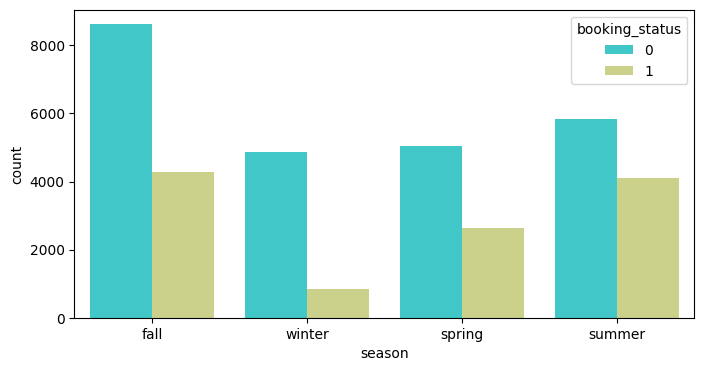

In [274]:
plt.figure(figsize = (8, 4))
sns.countplot(x = 'season', hue = 'booking_status', data = new_df, palette='rainbow')
plt.show()

In [275]:
contingency_table = pd.crosstab(new_df['booking_status'], new_df['season'])
res.chisq(df = contingency_table)
print(res.summary)


Chi-squared test for independence

Test              Df    Chi-square       P-value
--------------  ----  ------------  ------------
Pearson            3       1157.56  1.18218e-250
Log-likelihood     3       1267.96  1.31584e-274



In [276]:
# create a new categorical feature canceled_before to indicate whether has canceled for at least once previously 
new_df['canceled_before'] = new_df['no_of_previous_cancellations'].map(lambda x: 1 if x > 0 else 0)
contingency_table = pd.crosstab(new_df['booking_status'], new_df['canceled_before'])
print(contingency_table)

canceled_before      0    1
booking_status             
0                24038  322
1                11863   15


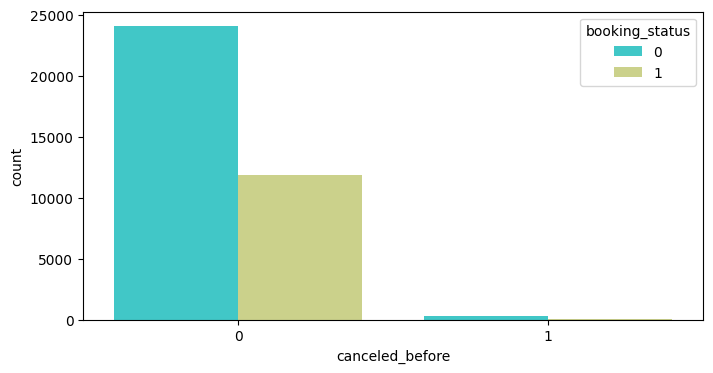

In [277]:
plt.figure(figsize = (8, 4))
sns.countplot(x = 'canceled_before', hue = 'booking_status', data = new_df, palette='rainbow')
plt.show()

In [278]:
contingency_table = pd.crosstab(new_df['booking_status'], new_df['canceled_before'])
res.chisq(df = contingency_table)
print(res.summary)


Chi-squared test for independence

Test              Df    Chi-square      P-value
--------------  ----  ------------  -----------
Pearson            1       122.582  1.72163e-28
Log-likelihood     1       165.362  7.62624e-38



In [294]:
features = new_df[['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_month', 'market_segment_type', 'repeated_guest',
       'avg_price_per_room', 'no_of_special_requests', 'season', 'canceled_before']]

target = new_df['booking_status']
from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [295]:
X_train_raw

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,market_segment_type,repeated_guest,avg_price_per_room,no_of_special_requests,season,canceled_before
3932,2,0,0,3,Meal Plan 1,0,Room_Type 1,160,12,Offline,0,70.00,0,winter,0
1895,2,0,1,2,Meal Plan 1,0,Room_Type 1,58,11,Online,0,79.20,1,fall,0
15188,1,0,0,2,Meal Plan 1,0,Room_Type 1,192,6,Offline,0,95.00,0,summer,0
1808,2,0,0,2,Meal Plan 2,0,Room_Type 1,346,9,Online,0,115.00,1,fall,0
27040,2,0,2,2,Meal Plan 1,0,Room_Type 1,76,11,Online,0,72.25,1,fall,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16869,2,0,0,2,Meal Plan 2,0,Room_Type 1,39,8,Offline,0,109.00,0,summer,0
6268,1,0,0,2,Meal Plan 1,0,Room_Type 1,4,5,Corporate,0,121.00,0,spring,0
11298,3,0,0,2,Meal Plan 1,0,Room_Type 4,52,7,Online,0,137.70,1,summer,0
860,2,0,0,3,Meal Plan 1,0,Room_Type 1,213,6,Online,0,130.00,0,summer,0


#### Numerical variables (7)
- no_of_adults: Number of adults
- no_of_children: Number of Children
- no_of_weekend_nights: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
- no_of_week_nights: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
- lead_time: Number of days between the date of booking and the arrival date
- avg_price_per_room: Average price per day of the reservation; prices of the rooms are dynamic. (in euros)
- no_of_special_requests: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)

#### Categorical variables (8)
- type_of_meal_plan: Type of meal plan booked by the customer:
- required_car_parking_space: Does the customer require a car parking space? (0 - No, 1- Yes)- 
- room_type_reserved: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.
- arrival_month: Month of arrival date
- market_segment_type: Market segment designation
- repeated_guest: Is the customer a repeated guest? (0 - No, 1- Yes)
- arrival_season
- canceled_before: Whether the customer has canceled for at least once previously (0 - No, 1- Yes)

In [296]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
num_features = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'lead_time', 'avg_price_per_room', 'no_of_special_requests']
cat_features = ['type_of_meal_plan', 'room_type_reserved', 'arrival_month', 'season','market_segment_type', 'canceled_before']

ct = ColumnTransformer(transformers=[('ohe', OneHotEncoder(drop = "if_binary"), cat_features),
                                     ('std', StandardScaler(), num_features)], remainder='passthrough', verbose_feature_names_out=False)

In [297]:
X_train = pd.DataFrame(ct.fit_transform(X_train_raw), columns = ct.get_feature_names_out())
X_train

,type_of_meal_plan_Meal Plan 1,type_of_meal_plan_Meal Plan 2,type_of_meal_plan_Meal Plan 3,type_of_meal_plan_Not Selected,room_type_reserved_Room_Type 1,room_type_reserved_Room_Type 2,room_type_reserved_Room_Type 3,room_type_reserved_Room_Type 4,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,...,canceled_before_1,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,avg_price_per_room,no_of_special_requests,required_car_parking_space,repeated_guest
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.303026,-0.259514,-0.929215,0.572074,0.861827,-0.957609,-0.784884,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.303026,-0.259514,0.225384,-0.143512,-0.321220,-0.694495,0.487912,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.622606,-0.259514,-0.929215,-0.143512,1.232979,-0.242626,-0.784884,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.303026,-0.259514,-0.929215,-0.143512,3.019148,0.329359,0.487912,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.303026,-0.259514,1.379982,-0.143512,-0.112447,-0.893260,0.487912,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28985,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.303026,-0.259514,-0.929215,-0.143512,-0.541591,0.157764,-0.784884,0.0,0.0
28986,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.622606,-0.259514,-0.929215,-0.143512,-0.947539,0.500955,-0.784884,0.0,0.0
28987,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,2.228659,-0.259514,-0.929215,-0.143512,-0.390811,0.978563,0.487912,0.0,0.0
28988,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.303026,-0.259514,-0.929215,0.572074,1.476547,0.758349,-0.784884,0.0,0.0


In [298]:
X_test = pd.DataFrame(ct.transform(X_test_raw), columns = ct.get_feature_names_out())

In [299]:
ct.get_feature_names_out()

array(['type_of_meal_plan_Meal Plan 1', 'type_of_meal_plan_Meal Plan 2',
       'type_of_meal_plan_Meal Plan 3', 'type_of_meal_plan_Not Selected',
       'room_type_reserved_Room_Type 1', 'room_type_reserved_Room_Type 2',
       'room_type_reserved_Room_Type 3', 'room_type_reserved_Room_Type 4',
       'room_type_reserved_Room_Type 5', 'room_type_reserved_Room_Type 6',
       'room_type_reserved_Room_Type 7', 'arrival_month_1',
       'arrival_month_2', 'arrival_month_3', 'arrival_month_4',
       'arrival_month_5', 'arrival_month_6', 'arrival_month_7',
       'arrival_month_8', 'arrival_month_9', 'arrival_month_10',
       'arrival_month_11', 'arrival_month_12', 'season_fall',
       'season_spring', 'season_summer', 'season_winter',
       'market_segment_type_Aviation',
       'market_segment_type_Complementary',
       'market_segment_type_Corporate', 'market_segment_type_Offline',
       'market_segment_type_Online', 'canceled_before_1', 'no_of_adults',
       'no_of_children', 'n

In [300]:
X_train_cat = X_train[['type_of_meal_plan_Meal Plan 1', 'type_of_meal_plan_Meal Plan 2',
       'type_of_meal_plan_Meal Plan 3', 'type_of_meal_plan_Not Selected',
       'room_type_reserved_Room_Type 1', 'room_type_reserved_Room_Type 2',
       'room_type_reserved_Room_Type 3', 'room_type_reserved_Room_Type 4',
       'room_type_reserved_Room_Type 5', 'room_type_reserved_Room_Type 6',
       'room_type_reserved_Room_Type 7', 'arrival_month_1', 'arrival_month_2', 'arrival_month_3',
       'arrival_month_4', 'arrival_month_5', 'arrival_month_6',
       'arrival_month_7', 'arrival_month_8', 'arrival_month_9',
       'arrival_month_10', 'arrival_month_11', 'arrival_month_12',
       'season_fall', 'season_spring', 'season_summer', 'season_winter',
       'market_segment_type_Aviation',
       'market_segment_type_Complementary',
       'market_segment_type_Corporate', 'market_segment_type_Offline',
       'market_segment_type_Online', 'canceled_before_1', 'required_car_parking_space',
       'repeated_guest']]

In [301]:
from sklearn.feature_selection import SelectKBest, chi2

fs = SelectKBest(score_func=chi2, k=20)
fs.fit(X_train_cat, y_train)

SelectKBest(k=20, score_func=<function chi2 at 0x17f041750>)

In [302]:
fs.get_feature_names_out()

array(['type_of_meal_plan_Meal Plan 1', 'type_of_meal_plan_Meal Plan 2',
       'room_type_reserved_Room_Type 6', 'arrival_month_1',
       'arrival_month_2', 'arrival_month_4', 'arrival_month_6',
       'arrival_month_7', 'arrival_month_8', 'arrival_month_10',
       'arrival_month_12', 'season_summer', 'season_winter',
       'market_segment_type_Complementary',
       'market_segment_type_Corporate', 'market_segment_type_Offline',
       'market_segment_type_Online', 'canceled_before_1',
       'required_car_parking_space', 'repeated_guest'], dtype=object)

In [303]:
def select_features(X_train, y_train, k_value='all'):
    fs = SelectKBest(score_func=chi2, k=k_value)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    return X_train_fs, fs
# feature selection
X_train_fs, fs = select_features(X_train_cat, y_train)
# what are scores for the features
#for i in range(len(fs.scores_)):
    #print('Feature %d: %f' % (i, fs.scores_[i]))

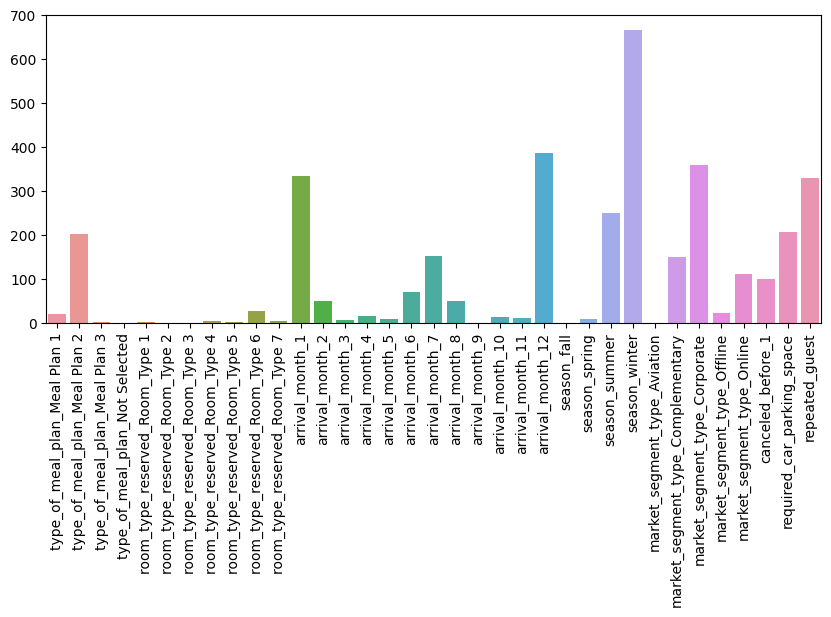

In [304]:
# scores for the features
names = []
values = []
for i in range(len(fs.scores_)):
    names.append(X_train_cat.columns[i])
    values.append(fs.scores_[i])
chi_list = zip(names, values)

# plot the scores
plt.figure(figsize=(10,4))
sns.barplot(x=names, y=values)
plt.xticks(rotation = 90)
plt.show()

### Logistic Regression

In [305]:
from sklearn.linear_model import LogisticRegression
baseline_lr = LogisticRegression(max_iter=100000, class_weight='balanced')
baseline_lr.fit(X_train, y_train)
y_train_pred = baseline_lr.predict(X_train)
y_test_pred = baseline_lr.predict(X_test)

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report

print(roc_auc_score(y_train, y_train_proba[:, 1]))
print(roc_auc_score(y_test, y_test_proba[:, 1]))

0.9748128999390496
0.9493111455128547


#### Hyperparameter tuning

In [87]:
from sklearn.model_selection import GridSearchCV

model_lr0 = LogisticRegression(penalty='elasticnet', solver='saga', random_state=2023, max_iter=100000, class_weight='balanced')

parameters = {'penalty': ['elasticnet'],
              'C': [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100],
              'l1_ratio': [0, 0.01, 0.033, 0.1, 0.33, 1]}
model_lr = GridSearchCV(model_lr0, parameters, cv = 3, n_jobs = -1, scoring='roc_auc',return_train_score=True)
model_lr = model_lr.fit(X_train, y_train)

In [88]:
print('AUC-ROC: %.5f' % model_lr.best_score_)
print('Config: %s' % model_lr.best_params_)

AUC-ROC: 0.87165
Config: {'C': 10, 'l1_ratio': 1, 'penalty': 'elasticnet'}


In [91]:
y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

target_names = ['Not canceled', 'Canceled']
print(classification_report(y_train, y_train_pred, target_names=target_names))
print(classification_report(y_test, y_test_pred, target_names=target_names))

              precision    recall  f1-score   support

Not canceled       0.88      0.78      0.83     19459
    Canceled       0.64      0.78      0.70      9531

    accuracy                           0.78     28990
   macro avg       0.76      0.78      0.77     28990
weighted avg       0.80      0.78      0.79     28990

              precision    recall  f1-score   support

Not canceled       0.87      0.79      0.83      4901
    Canceled       0.64      0.76      0.69      2347

    accuracy                           0.78      7248
   macro avg       0.75      0.77      0.76      7248
weighted avg       0.80      0.78      0.79      7248



In [92]:
y_train_proba = model_lr.predict_proba(X_train)
y_test_proba = model_lr.predict_proba(X_test)

print(roc_auc_score(y_train, y_train_proba[:, 1]))
print(roc_auc_score(y_test, y_test_proba[:, 1]))

0.8725249452953683
0.8686656210522673


In [99]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

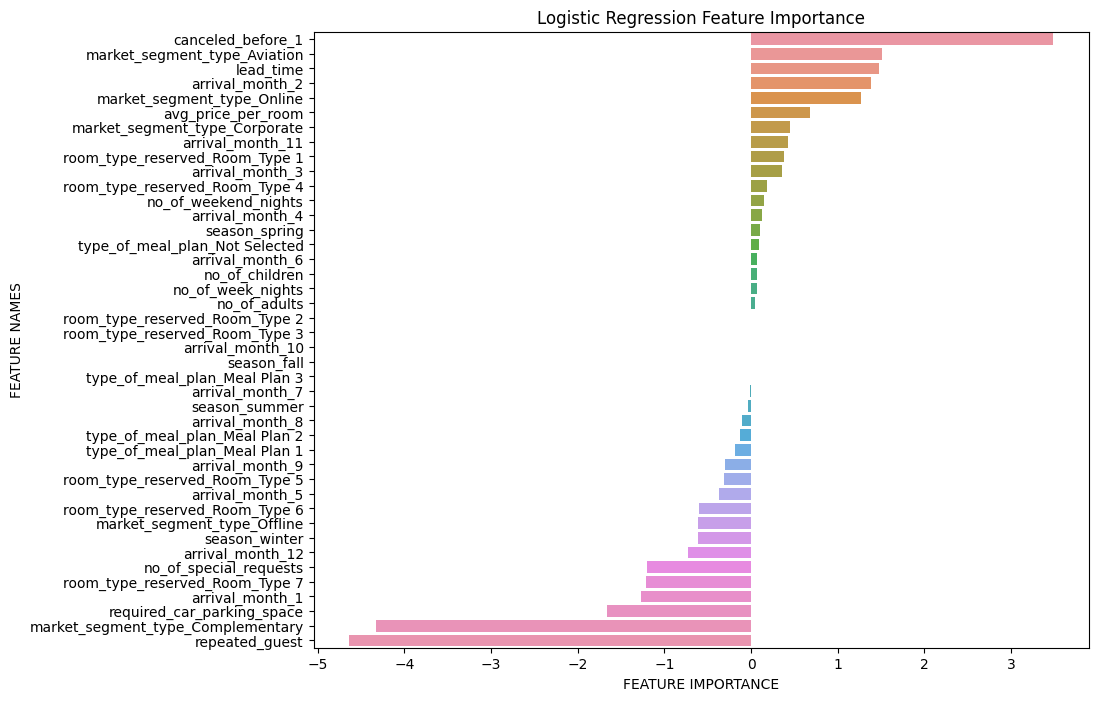

In [100]:
plot_feature_importance(model_lr.best_estimator_.coef_.flatten(),X_train.columns,'Logistic Regression')

### Random Forest

In [94]:
from sklearn.ensemble import RandomForestClassifier
baseline_rf = RandomForestClassifier()
baseline_rf.fit(X_train, y_train)
y_train_pred = baseline_rf.predict(X_train)
y_test_pred = baseline_rf.predict(X_test)

In [95]:
y_train_proba = baseline_rf.predict_proba(X_train)
y_test_proba = baseline_rf.predict_proba(X_test)
print(roc_auc_score(y_train, y_train_proba[:, 1]))
print(roc_auc_score(y_test, y_test_proba[:, 1]))

0.9992955010626363
0.9485358022375199


#### Hyperparameter tuning

In [123]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

model_rf0 = RandomForestClassifier(n_estimators=200, random_state=2023, class_weight='balanced', n_jobs=-1)

parameters = {'max_depth': [3, 6, 9, 15, 20, 30, 50],
              'min_samples_leaf': [1, 3, 5, 10, 20],
              'min_samples_split': [2, 3, 5, 8]
             }
model_rf = GridSearchCV(model_rf0, param_grid = parameters, scoring = 'roc_auc', cv = 3).fit(X_train, y_train)

print('AUC-ROC: %.5f' % model_rf.best_score_)
print('Config: %s' % model_rf.best_params_)

AUC-ROC: 0.94940
Config: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [175]:
y_train_proba = model_rf.predict_proba(X_train)
y_test_proba = model_rf.predict_proba(X_test)
print(roc_auc_score(y_train, y_train_proba[:, 1]))
print(roc_auc_score(y_test, y_test_proba[:, 1]))

0.9940613752029109
0.9539714206651739


In [186]:
y_train_pred = model_rf.predict(X_train)
y_test_pred = model_rf.predict(X_test)

target_names = ['Not canceled', 'Canceled']
print(classification_report(y_train, y_train_pred, target_names=target_names))
print(classification_report(y_test, y_test_pred, target_names=target_names))

              precision    recall  f1-score   support

Not canceled       0.97      0.96      0.97     19459
    Canceled       0.93      0.95      0.94      9531

    accuracy                           0.96     28990
   macro avg       0.95      0.96      0.95     28990
weighted avg       0.96      0.96      0.96     28990

              precision    recall  f1-score   support

Not canceled       0.91      0.93      0.92      4901
    Canceled       0.85      0.81      0.83      2347

    accuracy                           0.89      7248
   macro avg       0.88      0.87      0.88      7248
weighted avg       0.89      0.89      0.89      7248



0.3740924654695238
0.7865429234338747
0.8666382616105667


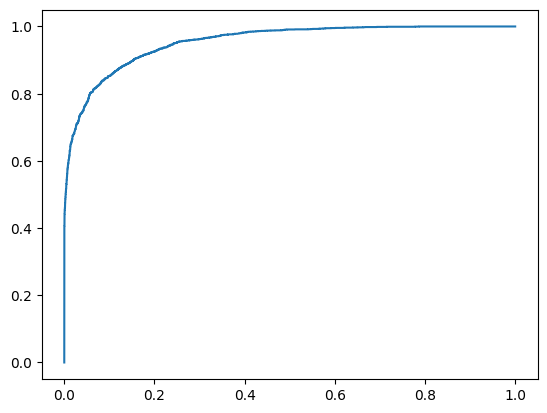

In [189]:
from sklearn.metrics import precision_score, recall_score, f1_score

fpr, tpr, threshold = roc_curve(y_test, y_test_proba[:, 1])
plt.plot(fpr, tpr)
# https://towardsdatascience.com/optimal-threshold-for-imbalanced-classification-5884e870c293
# choosing threshold
gmean = np.sqrt(tpr * (1 - fpr))
index = np.argmax(gmean)
th = threshold[index]
y_test_predic = (y_test_proba[:, 1] > th).astype(int)
precision = precision_score(y_test, y_test_predic, average="binary")
recall = recall_score(y_test, y_test_predic, average="binary")
print(th)
print(precision)
print(recall)

In [126]:
importances = model_rf.best_estimator_.feature_importances_

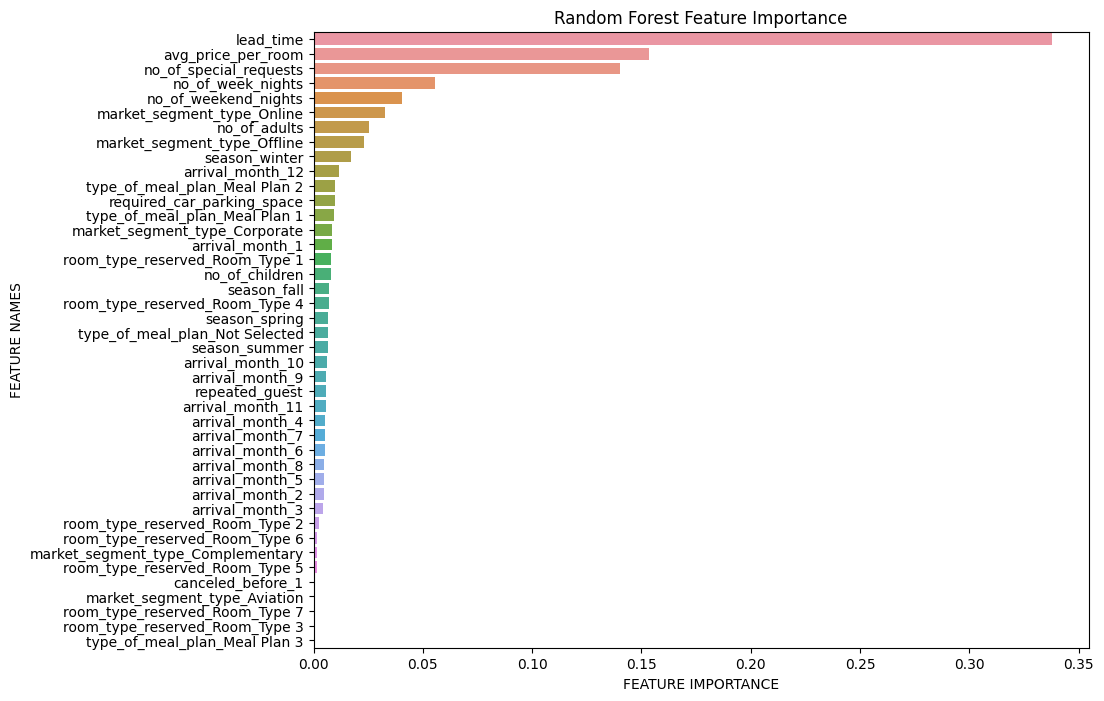

In [152]:
plot_feature_importance(importances,X_train.columns,'Random Forest')

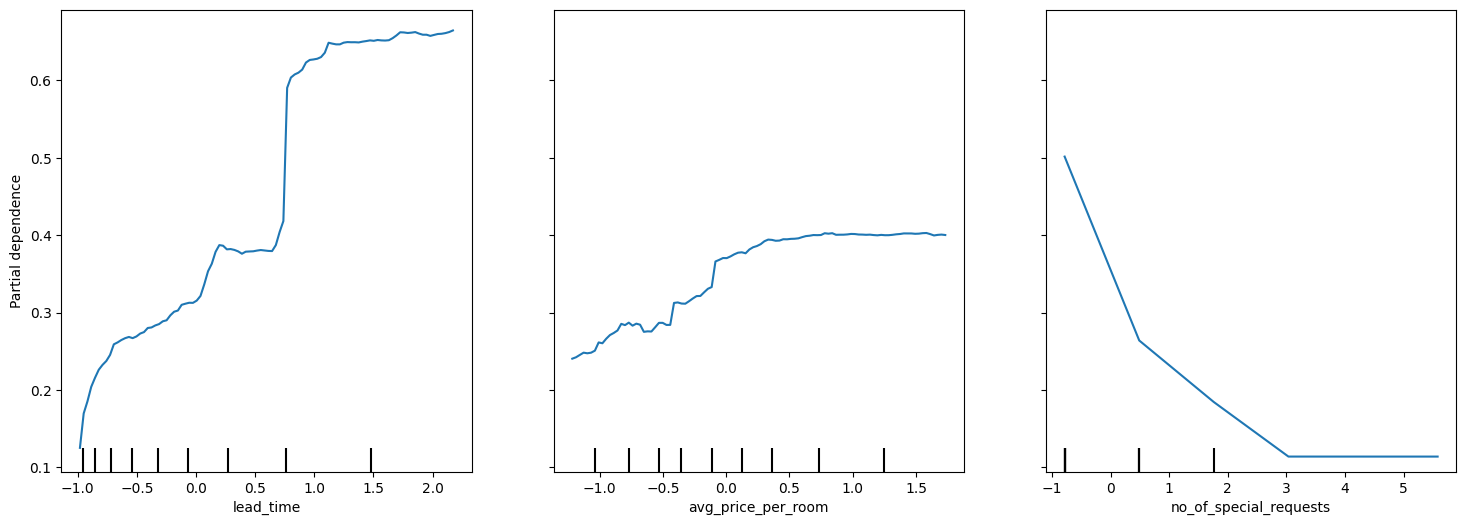

In [129]:
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(figsize=(18, 6))
idx_features = [X_train.columns.get_loc('lead_time'), X_train.columns.get_loc('avg_price_per_room'), X_train.columns.get_loc('no_of_special_requests')]
rf_disp = PartialDependenceDisplay.from_estimator(model_rf, X_train, idx_features, ax=ax)

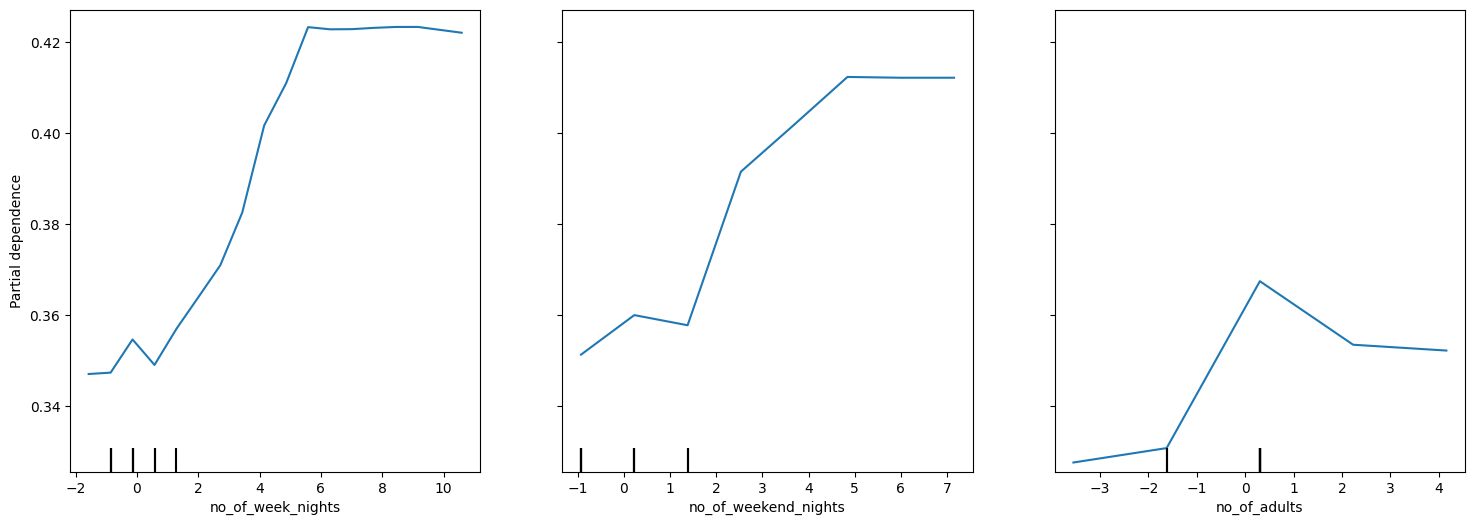

In [130]:
fig, ax = plt.subplots(figsize=(18, 6))
idx_features = [X_train.columns.get_loc('no_of_week_nights'), X_train.columns.get_loc('no_of_weekend_nights'), X_train.columns.get_loc('no_of_adults')]
rf_disp = PartialDependenceDisplay.from_estimator(model_rf, X_train, idx_features, ax=ax)

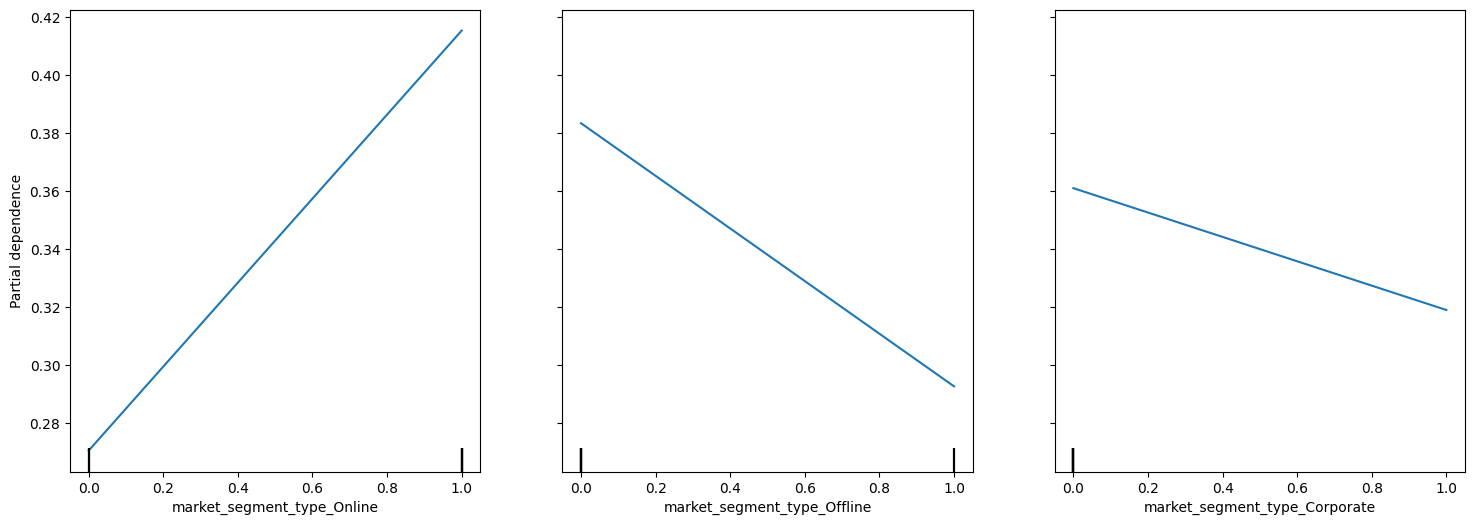

In [131]:
fig, ax = plt.subplots(figsize=(18, 6))
idx_features = [X_train.columns.get_loc('market_segment_type_Online'), X_train.columns.get_loc('market_segment_type_Offline'), X_train.columns.get_loc('market_segment_type_Corporate')]
rf_disp = PartialDependenceDisplay.from_estimator(model_rf, X_train, idx_features, ax=ax)

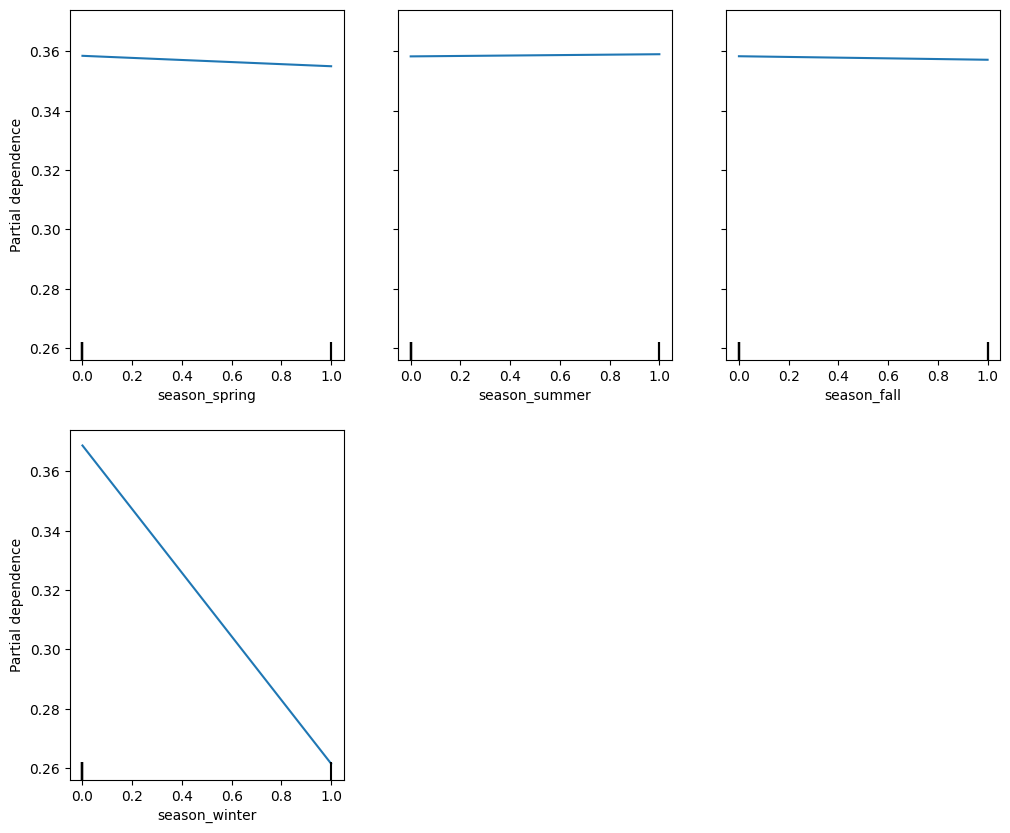

In [132]:
fig, ax = plt.subplots(figsize=(12, 10))
idx_features = [X_train.columns.get_loc('season_spring'), X_train.columns.get_loc('season_summer'), X_train.columns.get_loc('season_fall'), X_train.columns.get_loc('season_winter') ]
rf_disp = PartialDependenceDisplay.from_estimator(model_rf, X_train, idx_features, ax=ax)

### XGBoost

In [197]:
from xgboost import XGBClassifier

from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y = y_train)
baseline_xgb.fit(X_train, y_train, sample_weight=classes_weights)
y_train_pred = baseline_xgb.predict(X_train)
y_test_pred = baseline_xgb.predict(X_test)

In [198]:
y_train_proba = baseline_xgb.predict_proba(X_train)
y_test_proba = baseline_xgb.predict_proba(X_test)
print(roc_auc_score(y_train, y_train_proba[:, 1]))
print(roc_auc_score(y_test, y_test_proba[:, 1]))

0.9748128999390496
0.9493111455128547


In [170]:
parameters = {'max_depth': [3, 6, 9, 15, 20, 30, 50],
              'min_samples_leaf': [1, 3, 5, 10, 20],
              'min_samples_split': [2, 3, 5, 8]
             }
model_rf = GridSearchCV(model_rf0, param_grid = parameters, scoring = 'roc_auc', cv = 3).fit(X_train, y_train)

In [171]:
model_xgb0 = XGBClassifier(n_estimators=100, random_state=2023, n_jobs=-1)

parameters = {'gamma': [0.0, 0.1, 0.2, 0.3],
              'learning_rate': [0.05, 0.1],
              'max_depth': [3, 5, 10],
              'reg_alpha': [0, 0.1, 0.2],
              'min_child_weight': [3, 5, 7],
              'reg_lambda': [1]
             }

model_xgb = GridSearchCV(model_xgb0, param_grid = parameters, scoring = 'roc_auc', cv = 3, n_jobs = -1).fit(X_train, y_train, sample_weight=classes_weights)

print('AUC-ROC: %.5f' % model_xgb.best_score_)
print('Config: %s' % model_xgb.best_params_)

AUC-ROC: 0.94927
Config: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 3, 'reg_alpha': 0, 'reg_lambda': 1}


In [172]:
y_train_proba = model_xgb.predict_proba(X_train)
y_test_proba = model_xgb.predict_proba(X_test)
print(roc_auc_score(y_train, y_train_proba[:, 1]))
print(roc_auc_score(y_test, y_test_proba[:, 1]))

0.974751073833957
0.9525553987703873


In [173]:
y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

target_names = ['Not canceled', 'Canceled']
print(classification_report(y_train, y_train_pred, target_names=target_names))
print(classification_report(y_test, y_test_pred, target_names=target_names))

              precision    recall  f1-score   support

Not canceled       0.95      0.91      0.93     19459
    Canceled       0.84      0.90      0.87      9531

    accuracy                           0.91     28990
   macro avg       0.89      0.91      0.90     28990
weighted avg       0.91      0.91      0.91     28990

              precision    recall  f1-score   support

Not canceled       0.92      0.90      0.91      4901
    Canceled       0.81      0.84      0.82      2347

    accuracy                           0.88      7248
   macro avg       0.86      0.87      0.87      7248
weighted avg       0.88      0.88      0.88      7248



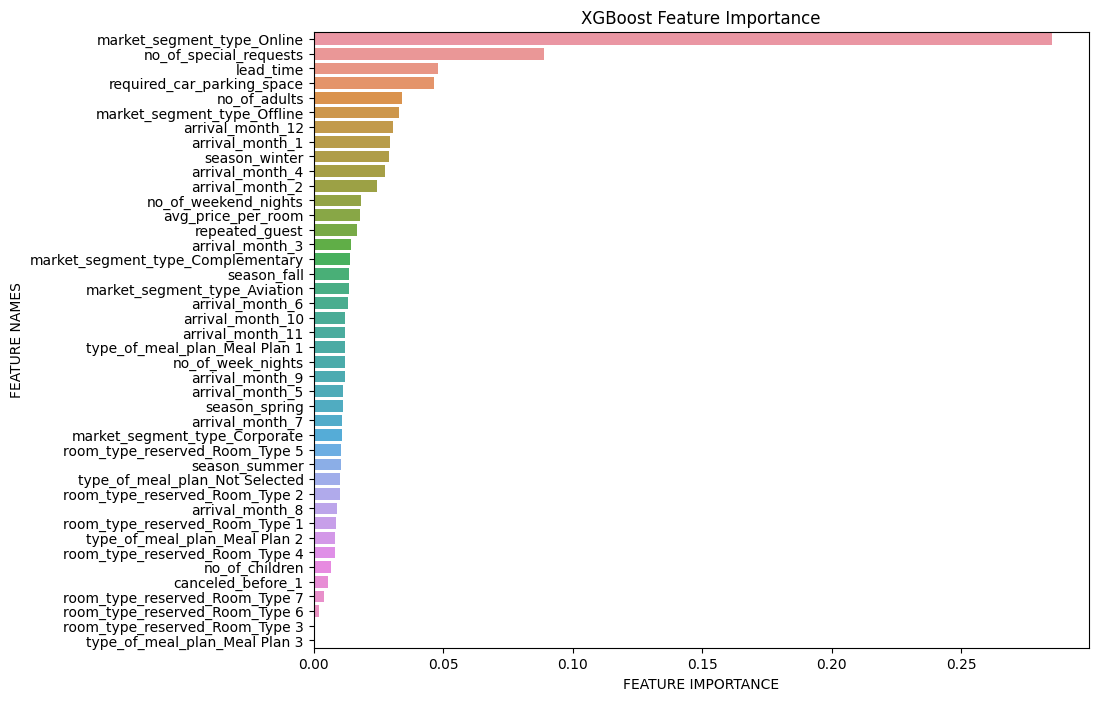

In [174]:
importances = model_xgb.best_estimator_.feature_importances_
plot_feature_importance(importances,X_train.columns,'XGBoost')

### Gradient Boosting Classifier

In [281]:
from sklearn.ensemble import GradientBoostingClassifier
baseline_gbm = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100)
baseline_gbm.fit(X_train,y_train)
y_train_pred = baseline_gbm.predict(X_train)
y_test_pred = baseline_gbm.predict(X_test)

target_names = ['Not canceled', 'Canceled']
print(classification_report(y_train, y_train_pred, target_names=target_names))
print(classification_report(y_test, y_test_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89     19459
           1       0.82      0.70      0.76      9531

    accuracy                           0.85     28990
   macro avg       0.84      0.81      0.83     28990
weighted avg       0.85      0.85      0.85     28990

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      4901
           1       0.83      0.67      0.74      2347

    accuracy                           0.85      7248
   macro avg       0.84      0.80      0.82      7248
weighted avg       0.85      0.85      0.84      7248



In [282]:
y_train_proba = baseline_gbm.predict_proba(X_train)
y_test_proba = baseline_gbm.predict_proba(X_test)
print(roc_auc_score(y_train, y_train_proba[:, 1]))
print(roc_auc_score(y_test, y_test_proba[:, 1]))

0.9169214590740812
0.912114359416576
